In [0]:
from google.colab import files
files.upload()

In [3]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c new-york-city-taxi-fare-prediction
!unzip train.csv.zip

  0%|                                                | 0.00/335k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 335k/335k [00:00<00:00, 62.2MB/s]
  0%|                                                | 0.00/960k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 960k/960k [00:00<00:00, 73.0MB/s]
100%|██████████████████████████████████████▉| 1.56G/1.56G [00:15<00:00, 146MB/s]
100%|███████████████████████████████████████| 1.56G/1.56G [00:15<00:00, 109MB/s]
  0%|                                                 | 0.00/486 [00:00<?, ?B/s]
100%|███████████████████████████████████████████| 486/486 [00:00<00:00, 563kB/s]
Archive:  train.csv.zip
  inflating: train.csv               


In [1]:
!ls -al

total 7200092
drwxr-xr-x 1 root root       4096 Sep 11 05:27 .
drwxr-xr-x 1 root root       4096 Sep 11 05:27 ..
drwxr-xr-x 4 root root       4096 Sep  7 20:29 .config
-rw-r--r-- 1 root root        486 Sep 11 05:27 GCP-Coupons-Instructions.rtf
-rw-r--r-- 1 root root         65 Sep 11 05:27 kaggle.json
drwxr-xr-x 2 root root       4096 Sep  7 20:49 sample_data
-rw-r--r-- 1 root root     343271 Sep 11 05:27 sample_submission.csv
-rw-r--r-- 1 root root     983020 Sep 11 05:27 test.csv
-rw-r--r-- 1 root root 5697178298 Jul 25 00:51 train.csv
-rw-r--r-- 1 root root 1674351600 Sep 11 05:27 train.csv.zip


# Get fastai library

In [2]:
!pip install git+https://github.com/fastai/fastai.git
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

  Cloning https://github.com/fastai/fastai.git to /tmp/pip-req-build-i9o9md1k
  Running setup.py bdist_wheel for fastai ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-rdz7aona/wheels/cf/46/39/b2d08762125ed2376861976ab2c4ac30c029b86e375735d9b8
Successfully built fastai


# Import the datasets

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.structured import *
from fastai.column_data import *

In [0]:
import pandas as pd 
import os

import matplotlib.pylab as plt
import numpy as np
%matplotlib inline

TRAIN_PATH = './train.csv'
TEST_PATH = './test.csv'

In [0]:
# To reproduce the value in the next time
#manual_seed = 555
#random.seed(manual_seed)
#np.random.seed(manual_seed)
#torch.manual_seed(manual_seed)
#torch.cuda.manual_seed_all(manual_seed)
torch.backends.cudnn.deterministic = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.cuda.current_device()
torch.cuda.device(0)
torch.cuda.device_count()
torch.cuda.get_device_name(0)
torch.cuda.is_available()
torch.cuda.set_device(0)

In [0]:
# For this plot and further analysis, we need a function to calculate the distance in miles between locations in lon,lat coordinates.
# This function is based on https://stackoverflow.com/questions/27928/
# calculate-distance-between-two-latitude-longitude-points-haversine-formula 
# return distance in miles
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...

def add_time(df):
    # add time information
    df['year'] = df.pickup_datetime.apply(lambda t: t.year)
    df['weekday'] = df.pickup_datetime.apply(lambda t: t.weekday())
    df['hour'] = df.pickup_datetime.apply(lambda t: t.hour)

def add_travel_vector_features(df):
    # add new column to dataframe with distance in miles
    df['distance_miles'] = distance(df.pickup_latitude, df.pickup_longitude, \
                                          df.dropoff_latitude, df.dropoff_longitude)
    #df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    #df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()
    #df['abs_diff_lon_lat'] = (df.abs_diff_longitude + df.abs_diff_latitude)

def add_airport_dist(df):
    """
    Return minumum distance from pickup or dropoff coordinates to each airport.
    JFK: John F. Kennedy International Airport
    EWR: Newark Liberty International Airport
    LGA: LaGuardia Airport
    """
    jfk_coord = (40.639722, -73.778889)
    ewr_coord = (40.6925, -74.168611)
    lga_coord = (40.77725, -73.872611)
    
    pickup_lat = df['pickup_latitude']
    dropoff_lat = df['dropoff_latitude']
    pickup_lon = df['pickup_longitude']
    dropoff_lon = df['dropoff_longitude']
    
    pickup_jfk = distance(pickup_lat, pickup_lon, jfk_coord[0], jfk_coord[1]) 
    dropoff_jfk = distance(jfk_coord[0], jfk_coord[1], dropoff_lat, dropoff_lon) 
    pickup_ewr = distance(pickup_lat, pickup_lon, ewr_coord[0], ewr_coord[1])
    dropoff_ewr = distance(ewr_coord[0], ewr_coord[1], dropoff_lat, dropoff_lon) 
    pickup_lga = distance(pickup_lat, pickup_lon, lga_coord[0], lga_coord[1]) 
    dropoff_lga = distance(lga_coord[0], lga_coord[1], dropoff_lat, dropoff_lon) 
    
    df['jfk_dist'] = pd.concat([pickup_jfk, dropoff_jfk], axis=1).min(axis=1)
    df['ewr_dist'] = pd.concat([pickup_ewr, dropoff_ewr], axis=1).min(axis=1)
    df['lga_dist'] = pd.concat([pickup_lga, dropoff_lga], axis=1).min(axis=1)

def add_features(df):
    add_time(df)
    add_travel_vector_features(df)
    add_airport_dist(df)
    
    return df

def drop_date(df):
    df = df.drop(['key', 'pickup_datetime'], axis=1)
    return df


def clean_df(df):
    print('Old size: %d' % len(df))
    
    # Remove observations with missing values
    df.dropna(how='any', axis='rows', inplace=True)

    # Removing observations with erroneous values
    mask = df['pickup_longitude'].between(-75, -73)
    mask &= df['dropoff_longitude'].between(-75, -73)
    mask &= df['pickup_latitude'].between(40, 42)
    mask &= df['dropoff_latitude'].between(40, 42)
    mask &= df['passenger_count'].between(0, 6)
    mask &= df['fare_amount'].between(0, 250)
    mask &= df['distance_miles'].between(0.05, 100)

    df = df[mask]
    
    print('New size: %d' % len(df))
    
    return df
  
def simplify(df):
    df.pickup_longitude += 74
    df.pickup_longitude *= 100
    df.pickup_latitude -= 40
    df.pickup_latitude *= 100

    df.dropoff_longitude += 74
    df.dropoff_longitude *= 100
    df.dropoff_latitude -= 40
    df.dropoff_latitude *= 100

    df.pickup_longitude = round(df.pickup_longitude, 0)
    df.pickup_latitude = round(df.pickup_latitude, 0)
    df.dropoff_longitude = round(df.dropoff_longitude, 0)
    df.dropoff_latitude = round(df.dropoff_latitude, 0)

    df.distance_miles = round(df.distance_miles, 1)
    df.jfk_dist = round(df.jfk_dist, 1)
    df.ewr_dist = round(df.ewr_dist, 1)
    df.lga_dist = round(df.lga_dist, 1)

    df.abs_diff_longitude = round(df.abs_diff_longitude, 3)
    df.abs_diff_latitude = round(df.abs_diff_latitude, 3)
    df.abs_diff_lon_lat = round(df.abs_diff_lon_lat, 3)
    
    return df

In [0]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

#

def shrink(df):
    df_float = df.select_dtypes(include=['float64'])
    converted_float = df.apply(pd.to_numeric,downcast='float')

    #print(mem_usage(df_float))
    #print(mem_usage(converted_float))

    compare_floats = pd.concat([df_float.dtypes,converted_float.dtypes],axis=1)
    compare_floats.apply(pd.Series.value_counts)

    #

    '''df_int = df.select_dtypes(include=['int64'])
    converted_int = df.apply(pd.to_numeric,downcast='integer')

    print(mem_usage(df_int))
    print(mem_usage(converted_int))

    compare_ints = pd.concat([df.dtypes,converted_int.dtypes],axis=1)
    compare_ints.apply(pd.Series.value_counts)'''

    #

    df[converted_float.columns] = converted_float
    #df[converted_int.columns] = converted_int

In [0]:
%%time

# Set columns to most suitable type to optimize for memory usage
traintypes = {'fare_amount': 'float32',
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float64',
              'pickup_latitude': 'float64',
              'dropoff_longitude': 'float64',
              'dropoff_latitude': 'float64',
              'passenger_count': 'uint8'}

cols = list(traintypes.keys())

df_list = []
df_chunk = pd.read_csv(TRAIN_PATH, usecols=cols, dtype=traintypes, nrows=10000000)
df_chunk['pickup_datetime'] = df_chunk['pickup_datetime'].str.slice(0, 16)
df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
df_list.append(df_chunk) 

In [7]:
%%time

chunksize = 10_000_000 # 5 million rows at one go. Or try 10 million

# Set columns to most suitable type to optimize for memory usage
traintypes = {'fare_amount': 'float32',
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float64',
              'pickup_latitude': 'float64',
              'dropoff_longitude': 'float64',
              'dropoff_latitude': 'float64',
              'passenger_count': 'uint8'}

cols = list(traintypes.keys())


df_list = [] # list to hold the batch dataframe
i=0

for df_chunk in pd.read_csv(TRAIN_PATH, usecols=cols, dtype=traintypes, chunksize=chunksize):
    
    # Neat trick from https://www.kaggle.com/btyuhas/bayesian-optimization-with-xgboost
    # Slicing off unnecessary components of the datetime and specifying the date 
    # format results in a MUCH more efficient conversion to a datetime object.
    df_chunk['pickup_datetime'] = df_chunk['pickup_datetime'].str.slice(0, 16)
    df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    
    # Can process each chunk of dataframe here
    #df_chunk = add_features(df_chunk)
    #df_chunk = clean_df(df_chunk)
    #shrink(df_chunk)
    
    # Alternatively, append the chunk to list and merge all
    df_list.append(df_chunk) 
    
# Merge all dataframes into one dataframe
#df = pd.concat(df_list)

# Delete the dataframe list to release memory
#del df_list

# See what we have loaded
#df.info()

CPU times: user 2min 15s, sys: 10.2 s, total: 2min 25s
Wall time: 2min 25s


# Pre-Process Data

In [8]:
CHUNK = 0

df_train = df_list[CHUNK].copy()
df_train = add_features(df_train)
df_train = clean_df(df_train)
#df_train = simplify(df_train)

Old size: 10000000
New size: 9632462


In [0]:
df_test = pd.read_csv('./test.csv')
df_test['pickup_datetime'] = df_test['pickup_datetime'].str.slice(0, 16)
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
df_test = add_features(df_test)
#df_test = simplify(df_test)

In [0]:
df = df.reset_index()

idx = np.random.randint(len(df), size=chunksize)
df_train = df.loc[idx]
#add_features(df_train)
#df_train = clean_df(df_train)


# Fastai

In [0]:
def rmse(y_pred, targ):
    return math.sqrt(((y_pred-targ)**2).mean())

In [0]:
'''cat_vars = ['passenger_count', 'year', 'weekday', 'hour']
cat_vars = ['year', 'weekday', 'hour']

contin_vars = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 
               'dropoff_latitude', 'distance_miles', 'abs_diff_longitude', 
               'abs_diff_latitude', 'abs_diff_lon_lat', 'jfk_dist', 'ewr_dist', 
               'lga_dist']'''

cat_vars = ['passenger_count', 'year', 'weekday', 'hour']
cat_vars = ['year', 'weekday', 'hour']

contin_vars = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 
               'dropoff_latitude', 'distance_miles', 'jfk_dist', 'ewr_dist', 
               'lga_dist']

In [0]:
dep = 'fare_amount'
df_train = df_train[cat_vars+contin_vars+[dep]].copy()
df_test = df_test[cat_vars+contin_vars].copy()

In [0]:
for v in cat_vars: 
    df_train[v] = df_train[v].astype('category').cat.as_ordered()
    df_test[v] = df_test[v].astype('category').cat.as_ordered()
  
apply_cats(df_train, df_test)

for v in contin_vars:
    df_train[v] = df_train[v].fillna(0).astype('float32')
    df_test[v] = df_test[v].fillna(0).astype('float32')

In [14]:
n = len(df_train); n

9632462

In [0]:
#df_train.info()
#df_test.info()

In [0]:
df_train, y, nas, mapper = proc_df(df_train, 'fare_amount', do_scale=True)
df_test, _, nas, mapper = proc_df(df_test, do_scale=True, mapper=mapper, na_dict=nas) # skip_flds=['Id']

In [0]:
for v in cat_vars: 
    df_train[v] = df_train[v].astype('category').cat.as_ordered()
    df_test[v] = df_test[v].astype('category').cat.as_ordered()
  
apply_cats(df_train, df_test)

for v in contin_vars:
    df_train[v] = df_train[v].fillna(0).astype('float32')
    df_test[v] = df_test[v].fillna(0).astype('float32')

In [0]:
val_idx = np.random.randint(n, size=int(n/10))

In [24]:
md = ColumnarModelData.from_data_frame('.', val_idx, df_train, y.astype(np.float32), cat_flds=cat_vars, bs=128,test_df=df_test)

cat_sz = [(c, len(df_train[c].cat.categories)+1) for c in cat_vars]
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

emb_szs

[(8, 4), (8, 4), (25, 13)]

In [28]:
m = md.get_learner(emb_szs, len(df_train.columns)-len(cat_vars), 
                   0, 1, [256,64,16], [0.,0.,0.])
m.summary()

OrderedDict([('Embedding-1',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 4]),
                           ('trainable', True),
                           ('nb_params', 32)])),
             ('Embedding-2',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 4]),
                           ('trainable', True),
                           ('nb_params', 32)])),
             ('Embedding-3',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 13]),
                           ('trainable', True),
                           ('nb_params', 325)])),
             ('Dropout-4',
              OrderedDict([('input_shape', [-1, 21]),
                           ('output_shape', [-1, 21]),
                           ('nb_params', 0)])),
             ('BatchNorm1d-5',
              OrderedDict([('input_shape', [-1, 8]),
                           ('output_shap

In [29]:
lr = 1e-4
m.lr_find()

 62%|██████▏   | 41965/68090 [07:15<04:31, 96.31it/s, loss=24.7]

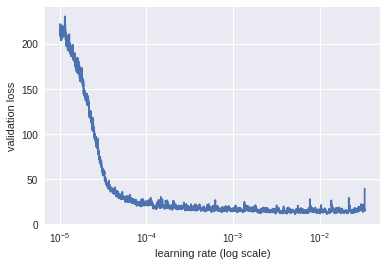

In [0]:
m.sched.plot(100)

## All

In [0]:
#m = md.get_learner(emb_szs, len(df_train.columns)-len(cat_vars),
#                   0.04, 1, [500,128,64], [0.001,0.01, 0.001])

# This was used for the results
'''m = md.get_learner(emb_szs, len(df_train.columns)-len(cat_vars), 
                   0.04, 1, [500,128], [0.001,0.01])'''

'''m = md.get_learner(emb_szs, len(df_train.columns)-len(cat_vars), 
                   0.4, 1, [500,64], [0.01,0.1])
'''

m = md.get_learner(emb_szs, len(df_train.columns)-len(cat_vars), 
                   0., 1, [256,64,16], [0.,0.,0.])


In [0]:
from google.colab import files
files.upload()

Saving trained.simplified.chunk1.model.h5 to trained.simplified.chunk1.model (1).h5


{'trained.simplified.chunk1.model.h5': b'\x80\x02\x8a\nl\xfc\x9cF\xf9 j\xa8P\x19.\x80\x02M\xe9\x03.\x80\x02}q\x00(X\x10\x00\x00\x00protocol_versionq\x01M\xe9\x03X\r\x00\x00\x00little_endianq\x02\x88X\n\x00\x00\x00type_sizesq\x03}q\x04(X\x05\x00\x00\x00shortq\x05K\x02X\x03\x00\x00\x00intq\x06K\x04X\x04\x00\x00\x00longq\x07K\x04uu.\x80\x02ccollections\nOrderedDict\nq\x00)Rq\x01(X\r\x00\x00\x00embs.0.weightq\x02ctorch._utils\n_rebuild_tensor\nq\x03((X\x07\x00\x00\x00storageq\x04ctorch\nFloatStorage\nq\x05X\x08\x00\x00\x0073187776q\x06X\x06\x00\x00\x00cuda:0q\x07K Ntq\x08QK\x00K\x08K\x04\x86q\tK\x04K\x01\x86q\ntq\x0bRq\x0cX\r\x00\x00\x00embs.1.weightq\rh\x03((h\x04h\x05X\x0f\x00\x00\x00139952082722304q\x0eX\x06\x00\x00\x00cuda:0q\x0fK Ntq\x10QK\x00K\x08K\x04\x86q\x11K\x04K\x01\x86q\x12tq\x13Rq\x14X\r\x00\x00\x00embs.2.weightq\x15h\x03((h\x04h\x05X\x0f\x00\x00\x00139952082722368q\x16X\x06\x00\x00\x00cuda:0q\x17ME\x01Ntq\x18QK\x00K\x19K\r\x86q\x19K\rK\x01\x86q\x1atq\x1bRq\x1cX\r\x00\x00\x00l

In [0]:
!cp trained.simplified.chunk1.model.h5 models

In [0]:
m.load('trained.simplified.chunk1.model')

In [32]:
%%time

lr = 5e-4
m.fit(lr, 10, metrics=[rmse])

epoch      trn_loss   val_loss   rmse       
    0      10.302872  10.194343  3.037156  
    1      8.793554   9.987878   3.013298  
    2      9.870545   9.783145   2.982057  
    3      12.303141  9.735384   2.973389  
    4      10.541178  9.648236   2.957309  
    5      9.507808   9.715771   2.971526  
    6      9.364871   9.618002   2.947611  
    7      10.366276  9.505487   2.934292  
    8      13.664396  9.758162   2.965721  
    9      11.75134   9.518649   2.930288  
CPU times: user 1h 47min 49s, sys: 21min 21s, total: 2h 9min 11s
Wall time: 2h 2min 49s


In [39]:
m.sched.rec_metrics

[3.0371559538357076,
 3.013298168466059,
 2.982057084415707,
 2.973388623131781,
 2.9573091094342256,
 2.971526384040752,
 2.947610640891534,
 2.934292444238039,
 2.9657213278974743,
 2.9302881626808057]

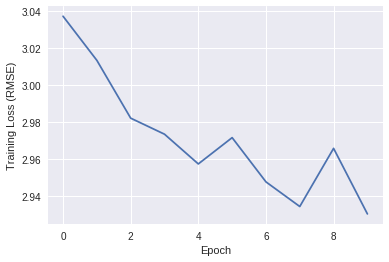

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(m.sched.rec_metrics)
plt.ylabel('Training Loss (RMSE)')
plt.xlabel('Epoch')
plt.show()

In [0]:
m.save('trained.chunk0.model')

In [0]:
files.download('./models/trained.chunk0.model.h5')

In [0]:
y_test = m.predict(True)

In [0]:
y_test = y_test.flatten('F').tolist()

In [44]:
df_temp = pd.read_csv('./test.csv')

#Create submission file
submission = pd.DataFrame({
        "key": df_temp['key'],
        "fare_amount": y_test
})

cols=["key","fare_amount"]
submission=submission.reindex(columns=cols)

submission.to_csv('submission_taxi_fare_nn_0.csv',index=False)
submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.065656
1,2015-01-27 13:08:24.0000003,11.161386
2,2011-10-08 11:53:44.0000002,4.592289
3,2012-12-01 21:12:12.0000002,7.338270
4,2012-12-01 21:12:12.0000003,13.480045


In [0]:
from google.colab import files
files.download('submission_taxi_fare_nn_0.csv')

In [46]:
submission.describe()

,fare_amount
count,9914.000000
mean,11.345961
std,9.009224
min,3.778941
25%,6.335170
50%,8.456523
75%,12.470649
max,107.710983


In [47]:
submission[submission.fare_amount > 80]

,key,fare_amount
643,2015-02-27 14:15:52.0000003,88.732849
4452,2015-05-25 22:13:09.0000002,96.877068
5115,2015-06-30 20:03:50.0000001,107.710983
6944,2014-06-14 13:39:00.000000149,89.882027
7857,2014-03-04 16:24:45.0000001,96.017296
8890,2014-12-24 03:00:00.00000020,85.011818
